Hola &#x1F600;

Soy **Hesus Garcia**  como "Jesús" pero con H. Sé que puede ser confuso al principio, pero una vez que lo recuerdes, ¡nunca lo olvidarás! &#x1F31D;	. Como revisor de código de Triple-Ten, estoy emocionado de examinar tus proyectos y ayudarte a mejorar tus habilidades en programación. si has cometido algún error, no te preocupes, pues ¡estoy aquí para ayudarte a corregirlo y hacer que tu código brille! &#x1F31F;. Si encuentro algún detalle en tu código, te lo señalaré para que lo corrijas, ya que mi objetivo es ayudarte a prepararte para un ambiente de trabajo real, donde el líder de tu equipo actuaría de la misma manera. Si no puedes solucionar el problema, te proporcionaré más información en la próxima oportunidad. Cuando encuentres un comentario,  **por favor, no los muevas, no los modifiques ni los borres**. 

Revisaré cuidadosamente todas las implementaciones que has realizado para cumplir con los requisitos y te proporcionaré mis comentarios de la siguiente manera:


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si todo está perfecto.
</div>

<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si tu código está bien pero se puede mejorar o hay algún detalle que le hace falta.
</div>

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si de pronto hace falta algo o existe algún problema con tu código o conclusiones.
</div>

Puedes responderme de esta forma:
<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> <a class=“tocSkip”></a>
</div>

</br>

**¡Empecemos!**  &#x1F680;

# Condiciones de la asignación principal

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

### Servicios de Interconnect

Interconnect proporciona principalmente dos tipos de servicios:

1. Comunicación por teléfono fijo. El teléfono se puede conectar a varias líneas de manera simultánea.
2. Internet. La red se puede configurar a través de una línea telefónica (DSL, *línea de abonado digital*) o a través de un cable de fibra óptica.

Algunos otros servicios que ofrece la empresa incluyen:

- Seguridad en Internet: software antivirus (*ProtecciónDeDispositivo*) y un bloqueador de sitios web maliciosos (*SeguridadEnLínea*).
- Una línea de soporte técnico (*SoporteTécnico*).
- Almacenamiento de archivos en la nube y backup de datos (*BackupOnline*).
- Streaming de TV (*StreamingTV*) y directorio de películas (*StreamingPelículas*)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción.

### Descripción de los datos

Los datos consisten en archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;
- `personal.csv` — datos personales del cliente;
- `internet.csv` — información sobre los servicios de Internet;
- `phone.csv` — información sobre los servicios telefónicos.

En cada archivo, la columna `customerID` (ID de cliente) contiene un código único asignado a cada cliente. La información del contrato es válida a partir del 1 de febrero de 2020.

# Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from IPython.display import HTML
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve,accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, RFE

# Importacion de datos

In [2]:
# Importamos archivos
df_contract = pd.read_csv("/datasets/final_provider/contract.csv")
df_internet = pd.read_csv("/datasets/final_provider/internet.csv")
df_personal = pd.read_csv("/datasets/final_provider/personal.csv")
df_phone = pd.read_csv("/datasets/final_provider/phone.csv")

# Funciones

In [3]:
def mostrarInfo(df, nombre):
    display(HTML(f'<h1> {nombre}'))
    display(df.sample(10))
    display(df.info())
    display(df.describe())
    display(df.isnull().sum())
    display(HTML('<hr>'))  

def ajustar_columnas(df):
    return df.columns.str.lower()

def convertir_fechas(df, columnas):
    for col in columnas:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    return df

def unificar_datasets(df_contract, df_personal, df_internet, df_phone):
    df_combined = pd.merge(df_contract, df_personal, on='customerid')
    df_combined = pd.merge(df_combined, df_internet, on='customerid', how='left')
    df_combined = pd.merge(df_combined, df_phone, on='customerid', how='left')
    return df_combined

def convertir_categoricas(df, excluidas):
    df_dummies = pd.get_dummies(df.drop(columns=excluidas), drop_first=True)
    return pd.concat([df[excluidas], df_dummies], axis=1)

def normalizar_numericas(df, columnas):
    scaler = StandardScaler()
    df[columnas] = scaler.fit_transform(df[columnas])
    return df

def rellenar_valores_faltantes(df):
    # Convertir booleanos a enteros
    df = df.astype({col: 'int' for col in df.select_dtypes(include=['bool']).columns})
    
    for column in df.columns:
        if df[column].dtype == 'float64' or df[column].dtype == 'int64':
            # Rellenar con la media para variables numéricas
            imputer = SimpleImputer(strategy='mean')
        else:
            # Rellenar con la moda para variables categóricas
            imputer = SimpleImputer(strategy='most_frequent')
        df[column] = imputer.fit_transform(df[[column]])
    return df

# Función para evaluar el modelo
def evaluar_modelo(modelo, X_train, y_train, X_test, y_test):
    modelo.fit(X_train, y_train)
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)
    y_prob_test = modelo.predict_proba(X_test)[:, 1]
    
    print(f"Modelo: {modelo.__class__.__name__}")
    print("Conjunto de Entrenamiento")
    print("Accuracy:", accuracy_score(y_train, y_pred_train))
    print("Classification Report:\n", classification_report(y_train, y_pred_train))
    print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_train))
    
    print("Conjunto de Prueba")
    print("Accuracy:", accuracy_score(y_test, y_pred_test))
    auc_roc = roc_auc_score(y_test, y_prob_test)
    print("AUC-ROC:", auc_roc)
    print("Classification Report:\n", classification_report(y_test, y_pred_test))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
    
    # Trazar la curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob_test)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_roc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {modelo.__class__.__name__}')
    plt.legend(loc="lower right")
    plt.show()

    return auc_roc, accuracy_score(y_test, y_pred_test)

def evaluar_y_medicion_tiempo(modelo_grid, X_train, y_train, X_test, y_test):
    inicio = time.time()
    modelo_grid.fit(X_train, y_train)
    fin = time.time()
    tiempo_entrenamiento = fin - inicio
    
    mejor_modelo = modelo_grid.best_estimator_
    auc_roc, accuracy = evaluar_modelo(mejor_modelo, X_train, y_train, X_test, y_test)
    
    return modelo_grid.best_params_, auc_roc, accuracy, tiempo_entrenamiento

# Filtrado: Selección de características utilizando chi-cuadrado
def seleccion_caracteristicas_filtrado(X, y, k=10):
    # Normalizar los datos para chi-cuadrado
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Selección de las mejores características
    selector = SelectKBest(score_func=chi2, k=k)
    X_nuevas = selector.fit_transform(X_scaled, y)
    return X_nuevas, selector.get_support(indices=True)

# Plan de trabajo

Deberás realizar un análisis exploratorio de datos. Al final de Jupyter Notebook, escribe:

- una lista de preguntas aclaratorias;
- un plan aproximado para resolver la tarea, que especifica de 3 a 5 pasos básicos y los explica en uno o dos enunciados.

El líder del equipo revisará tus preguntas y plan de trabajo. Las preguntas serán respondidas durante una videollamada. El código será revisado por el líder del equipo solo si hay algunas dudas.

# EDA

## Correcciones de data frames

## Mostrar informacion de los dataframes

In [4]:
# Contracts ------------------------|
mostrarInfo(df_contract, 'Contract')
# Internet -------------------------|
mostrarInfo(df_internet, 'Internet')
# Personal -------------------------|
mostrarInfo(df_personal, 'Personal')
# Phone ----------------------------|
mostrarInfo(df_phone, 'Phone')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
6138,4833-QTJNO,2014-07-01,No,Month-to-month,No,Bank transfer (automatic),83.85,5588.8
5481,8473-VUVJN,2019-09-01,2019-10-01 00:00:00,Month-to-month,Yes,Electronic check,73.65,73.65
6330,9921-QFQUL,2018-03-01,No,Month-to-month,No,Mailed check,90.15,2044.95
380,5651-CRHKQ,2016-09-01,No,One year,Yes,Bank transfer (automatic),86.20,3339.05
4408,2824-DXNKN,2014-02-01,No,Two year,Yes,Bank transfer (automatic),71.45,5025.85
1336,3733-LSYCE,2018-11-01,No,Month-to-month,No,Bank transfer (automatic),75.35,1114.55
5409,6005-OBZPH,2017-11-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,89.15,2277.65
3542,1301-LOPVR,2017-09-01,No,One year,Yes,Credit card (automatic),55.35,1636.95
4035,1485-YDHMM,2015-10-01,No,Month-to-month,Yes,Bank transfer (automatic),93.25,4631.7
1861,7054-LGEQW,2019-09-01,2019-10-01 00:00:00,Month-to-month,No,Mailed check,45.95,45.95


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1038,5989-OMNJE,DSL,Yes,Yes,Yes,No,Yes,Yes
1131,5357-TZHPP,Fiber optic,No,No,No,No,No,Yes
795,1374-DMZUI,Fiber optic,No,No,No,No,Yes,Yes
4751,3097-NQYSN,Fiber optic,No,No,No,No,Yes,No
2487,6568-POCUI,Fiber optic,No,No,No,Yes,Yes,Yes
3092,9861-PDSZP,Fiber optic,No,Yes,Yes,Yes,Yes,Yes
4983,0702-PGIBZ,Fiber optic,No,Yes,No,No,Yes,Yes
4073,3034-ZBEQN,DSL,No,Yes,Yes,No,No,No
774,9117-SHLZX,DSL,No,No,No,No,No,No
2951,5960-WPXQM,Fiber optic,No,No,No,No,Yes,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

,customerID,gender,SeniorCitizen,Partner,Dependents
3191,7636-OWBPG,Male,1,No,No
593,0215-BQKGS,Male,0,No,No
545,7129-AZJDE,Male,0,Yes,Yes
6090,9625-QNLUX,Male,0,Yes,Yes
170,7654-YWJUF,Male,0,Yes,No
5975,1522-VVDMG,Male,0,Yes,Yes
3984,5884-FBCTL,Female,0,Yes,Yes
2171,3995-WFCSM,Female,0,No,No
2533,5397-NSKQG,Male,0,Yes,Yes
3255,4827-LTQRJ,Female,1,Yes,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

,customerID,MultipleLines
5771,6368-TZZDT,No
2907,5501-TVMGM,No
5647,6394-HHHZM,No
6245,9108-EJFJP,No
1229,5624-RYAMH,No
2645,9522-ZSINC,No
4116,4910-AQFFX,Yes
5644,9962-BFPDU,No
4770,8634-CILSZ,Yes
5586,7779-ORAEL,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


customerID       0
MultipleLines    0
dtype: int64

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>
Gran trabajo con la exploración inicial. Tienes muy bien interiorizado el proceso. Para seguir mejorando te aconsejo intentar integrar esto en tus propias funciones. 
</div>


### Conclusion sobre los datos

Calidad de los datos 

1. Los cuatro conjuntos de datos (contratos, internet, personal, y teléfono) están libres de valores nulos y duplicados. Esto indica una alta calidad en la gestión y mantenimiento de los registros de los clientes.
   
2. Cada conjunto de datos incluye todos los registros esperados con completitud en todas las columnas esenciales, lo que permite una integración y comparación efectiva entre diferentes tipos de información del cliente.

Caracteristicas de los datos

1. Contratos (Contract): Los datos muestran una variedad de tipos de contratos (mes a mes, anual, y bianual), diferentes métodos de pago, y una amplia gama de cargos mensuales. La columna TotalCharges está clasificada como objeto, lo que podría necesitar una conversión a tipo numérico para análisis futuros.

2. Servicios de Internet(internet): Los servicios de internet son variados, incluyendo DSL y fibra óptica, y opciones adicionales como seguridad en línea, respaldo en línea, protección de dispositivos, soporte técnico, y servicios de streaming. Esto refleja una diversidad de ofertas que pueden influir en la satisfacción y retención del cliente.

3. Información Personal(personal): Incluye género, si el cliente es un ciudadano senior, y detalles familiares como si tienen pareja o dependientes. Esta información puede ser crucial para segmentar la base de clientes y entender diferentes comportamientos y necesidades.

4. Servicios de Teléfono(Phone): Aproximadamente la mitad de los clientes tienen múltiples líneas, lo que podría estar correlacionado con mayores necesidades de comunicación o mayores niveles de gasto en servicios.

Potencial de Análisis Futuros

1. Análisis Predictivo: Los datos están bien preparados para construir modelos predictivos de churn (cancelación de servicios) basados en características contractuales, personales, y de servicio. Especialmente, la diversidad en tipos de servicios y características del cliente ofrece una oportunidad rica para explorar qué factores influyen más significativamente en la lealtad del cliente.

2. Segmentación del Cliente: Utilizar la información demográfica y de servicios para segmentar la base de clientes podría ayudar a Interconnect a personalizar sus ofertas y estrategias de retención.

3. Optimización de Ofertas: Analizar la relación entre los tipos de servicios contratados y la satisfacción del cliente podría permitir a Interconnect optimizar sus paquetes de servicios para maximizar la retención.

### Preguntas aclaratorias 

1. ¿Por qué hay fechas de contratos anteriores al 1 de febrero de 2020 si se menciona que la información es válida a partir de esa fecha?
2. ¿Existen detalles adicionales sobre el historial de pagos y posibles impagos que puedan ser relevantes para el análisis de cancelación?
3. ¿Hay datos disponibles sobre el uso específico de servicios adicionales como StreamingTV y OnlineSecurity? ¿Podemos acceder a métricas de uso como horas de uso o frecuencia de interacción?

### Plan de trabajo

1. Preparación de Datos

    - Ajuste y Limpieza: Ajustar nombres de columnas a minúsculas, convertir fechas a tipos de datos adecuados y unificar los datasets para incluir información de todos los servicios. Esto también incluye la conversión de variables categóricas en numéricas y la normalización de las variables numéricas.

    - Equilibrio de Clases: Examinar y ajustar el equilibrio de clases para la variable objetivo de cancelación.

2. Modelado Predictivo Inicial

    - Modelo Base: Entrenar y evaluar un modelo de regresión logística como modelo base para la predicción de cancelación de clientes. Este modelo inicial proporcionará un punto de referencia para evaluar modelos más complejos.

    - Selección de Modelos: Probar otros modelos de clasificación supervisada como Árboles de Decisión, Random Forest, Gradient Boosting Machines (GBM) y XGBoost.

3. Optimización y Evaluación

    - Optimización de Modelos: Seleccionar el modelo más óptimo basado en métricas de evaluación (precision, recall, f1-score, AUC-ROC) y ajustar hiperparámetros utilizando métodos iterativos.

    - Evaluación Final: Evaluar el modelo final con el conjunto de pruebas y realizar validaciones cruzadas para asegurar la robustez del modelo.

<div class="alert alert-block alert-warning">
¿Por qué hay fechas de contratos anteriores al 1 de febrero de 2020 si se menciona que la información es válida a partir de esa fecha?

Parece que hay un error en la descripción del proyecto indicando que la información es válida a partir del 1 de febrero de 2020, pero encontramos fechas de contratos anteriores a esa fecha en los datos. Este tipo de discrepancias es común en proyectos reales y puede deberse a suposiciones incorrectas o a una descripción incompleta de los datos. Procederemos considerando todas las fechas disponibles en los datos y aclararemos cualquier ambigüedad durante el análisis.

¿Existen detalles adicionales sobre el historial de pagos y posibles impagos que puedan ser relevantes para el análisis de cancelación?

Actualmente, no tenemos datos adicionales sobre el historial de pagos e impagos. Este tipo de información puede ser crucial para predecir la cancelación de servicios, ya que los clientes con historial de impagos podrían tener una mayor probabilidad de cancelación. Sería beneficioso obtener estos datos si están disponibles en el futuro.

¿Hay datos disponibles sobre el uso específico de servicios adicionales como StreamingTV y OnlineSecurity? ¿Podemos acceder a métricas de uso como horas de uso o frecuencia de interacción?

No disponemos de datos sobre el uso específico de los servicios adicionales como StreamingTV y OnlineSecurity. Contar con métricas de uso, como horas de uso o frecuencia de interacción, podría enriquecer significativamente nuestro análisis y permitir una mejor comprensión de cómo el uso de estos servicios influye en la retención de clientes. Si estos datos se vuelven disponibles en el futuro, deberían ser incorporados en el análisis.</div>

<div class="alert alert-block alert-info">
    
**Comentario del revisor: Importancia de la Selección de Características**

Es crucial incluir una sección de selección de características en tu plan de trabajo. La selección de características ayuda a identificar las variables más relevantes y elimina aquellas que no aportan valor al modelo, mejorando así el rendimiento y reduciendo el tiempo de entrenamiento.

Existen tres enfoques principales para la selección de características:

1. **Filtrado:**
   - **Métodos:** Correlación, chi-cuadrado, análisis de varianza (ANOVA)
   - **Descripción:** Utiliza técnicas estadísticas para evaluar la relación entre cada característica y la variable objetivo de forma independiente.
   - **Ventajas:** Simple y rápido, ideal para una primera criba de características.

2. **Wrapping:**
   - **Métodos:** Recursive Feature Elimination (RFE), Sequential Feature Selection
   - **Descripción:** Utiliza un modelo de machine learning para evaluar la combinación de características seleccionadas, iterando y eliminando características menos importantes.
   - **Ventajas:** Considera las interacciones entre características, proporcionando una selección más precisa.

3. **Embedding:**
   - **Métodos:** Regularización (Lasso, Ridge), modelos basados en árboles (Random Forest, Gradient Boosting)
   - **Descripción:** Realiza la selección de características durante el proceso de entrenamiento del modelo, integrando la importancia de características directamente en el modelo.
   - **Ventajas:** Muy efectivo para modelos complejos, ya que se adapta automáticamente a las características más importantes.

La selección de características no solo mejora la eficiencia del modelo, sino que también proporciona insights valiosos sobre la importancia relativa de cada característica. Esto es esencial para interpretar los resultados y hacer recomendaciones basadas en datos sólidos.

Recomiendo encarecidamente agregar esta sección para asegurar que tu análisis y modelos sean robustos, eficientes y más fáciles de interpretar.
</div>


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

¡Impresionante esfuerzo en este proyecto! 🌟 **Este proyecto está listo para ser aprobado.**<br>

Este plan de proyecto y sus propuestas son adecuadas para procesar los datos y avanzar. Te aconsejo que continúes a la siguiente sección y entregues el código correspondiente.

Es un placer reconocer tu dedicación y el análisis detallado que has llevado a cabo. Continúa superándote en tus futuras iniciativas. Confío en que aplicarás este conocimiento de manera efectiva en desafíos futuros, avanzando hacia objetivos aún más ambiciosos.
</div>


# Preparacion de datos

In [5]:
# Ajustar nombres de columnas
df_contract.columns = ajustar_columnas(df_contract)
df_internet.columns = ajustar_columnas(df_internet)
df_personal.columns = ajustar_columnas(df_personal)
df_phone.columns = ajustar_columnas(df_phone)

# Convertir fechas a tipos de datos adecuados
df_contract = convertir_fechas(df_contract, ['begindate', 'enddate'])
df_contract['totalcharges'] = pd.to_numeric(df_contract['totalcharges'], errors='coerce')

# Unificar datasets
df_combined = unificar_datasets(df_contract, df_personal, df_internet, df_phone)

# Crear columna churn antes de OHE
df_combined['churn'] = np.where(df_combined['enddate'].isna(), 0, 1)

# Eliminar columnas que generen ruido al modelo
df_combined_ohe = df_combined.drop(['customerid', 'begindate', 'enddate'], axis=1)

# Tratar los valores nulos para que el OHE genere columnas para clientes que no solicitaron este servicio
columns_to_replace_nan = ['internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines']
df_combined_ohe[columns_to_replace_nan] = df_combined_ohe[columns_to_replace_nan].fillna('noservice')

# Convertir variables categóricas en numéricas con OHE
df_combined_ohe = convertir_categoricas(df_combined_ohe, ['churn'])

# Normalizar las variables numéricas
numeric_features = ['monthlycharges', 'totalcharges']
df_combined_ohe = normalizar_numericas(df_combined_ohe, numeric_features)

# Resetear el índice para asegurarse de que 'customerid' no se pierde
df_combined_ohe.reset_index(drop=True, inplace=True)

# Rellenar valores faltantes
df_combined_ohe = rellenar_valores_faltantes(df_combined_ohe)

# Verificar el resultado final
mostrarInfo(df_combined_ohe, "Datasets unificados")


C:\Users\ejfra\AppData\Local\Temp\ipykernel_20876\749436127.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


,churn,monthlycharges,totalcharges,seniorcitizen,type_One year,type_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,...,deviceprotection_Yes,deviceprotection_noservice,techsupport_Yes,techsupport_noservice,streamingtv_Yes,streamingtv_noservice,streamingmovies_Yes,streamingmovies_noservice,multiplelines_Yes,multiplelines_noservice
2563,1,1.368932,0.164099,1.0,0,0,0,0,0,1,...,1,0,0,0,1,0,1,0,1,0
6795,0,0.675963,1.022518,0.0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2709,0,-0.359337,-0.029957,1.0,0,0,1,0,1,0,...,1,0,0,0,1,0,1,0,0,1
4606,0,-1.321517,-0.874698,0.0,0,1,0,0,0,1,...,0,1,0,1,0,1,0,1,1,0
2533,0,-0.460706,0.440459,0.0,0,1,0,1,0,0,...,0,0,0,0,1,0,1,0,0,1
5565,1,-0.854552,-0.711834,0.0,0,0,1,0,1,0,...,1,0,0,0,1,0,0,0,0,1
636,0,1.152899,0.364685,0.0,0,1,0,0,0,0,...,1,0,1,0,1,0,1,0,0,0
3075,0,1.360623,2.289255,0.0,1,0,1,0,0,0,...,1,0,0,0,1,0,1,0,1,0
5965,0,-0.035286,-0.041825,0.0,1,0,1,1,0,0,...,1,0,0,0,0,0,1,0,0,0
4897,0,-1.148690,-0.800160,0.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   churn                                  7043 non-null   int32  
 1   monthlycharges                         7043 non-null   float64
 2   totalcharges                           7043 non-null   float64
 3   seniorcitizen                          7043 non-null   float64
 4   type_One year                          7043 non-null   int32  
 5   type_Two year                          7043 non-null   int32  
 6   paperlessbilling_Yes                   7043 non-null   int32  
 7   paymentmethod_Credit card (automatic)  7043 non-null   int32  
 8   paymentmethod_Electronic check         7043 non-null   int32  
 9   paymentmethod_Mailed check             7043 non-null   int32  
 10  gender_Male                            7043 non-null   int32  
 11  part

None

,churn,monthlycharges,totalcharges,seniorcitizen,type_One year,type_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,...,deviceprotection_Yes,deviceprotection_noservice,techsupport_Yes,techsupport_noservice,streamingtv_Yes,streamingtv_noservice,streamingmovies_Yes,streamingmovies_noservice,multiplelines_Yes,multiplelines_noservice
count,7043.000000,7.043000e+03,7.043000e+03,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,...,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.265370,-6.406285e-17,8.146575e-17,0.162147,0.209144,0.240664,0.592219,0.216101,0.335794,0.228880,...,0.343888,0.216669,0.290217,0.216669,0.384353,0.216669,0.387903,0.216669,0.421837,0.096834
std,0.441561,1.000071e+00,9.992897e-01,0.368612,0.406726,0.427517,0.491457,0.411613,0.472301,0.420141,...,0.475038,0.412004,0.453895,0.412004,0.486477,0.412004,0.487307,0.412004,0.493888,0.295752
min,0.000000,-1.545860e+00,-9.990692e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-9.725399e-01,-8.299069e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.857327e-01,-3.894584e-01,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,8.338335e-01,6.632369e-01,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.794352e+00,2.824261e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


churn                                    0
monthlycharges                           0
totalcharges                             0
seniorcitizen                            0
type_One year                            0
type_Two year                            0
paperlessbilling_Yes                     0
paymentmethod_Credit card (automatic)    0
paymentmethod_Electronic check           0
paymentmethod_Mailed check               0
gender_Male                              0
partner_Yes                              0
dependents_Yes                           0
internetservice_Fiber optic              0
internetservice_noservice                0
onlinesecurity_Yes                       0
onlinesecurity_noservice                 0
onlinebackup_Yes                         0
onlinebackup_noservice                   0
deviceprotection_Yes                     0
deviceprotection_noservice               0
techsupport_Yes                          0
techsupport_noservice                    0
streamingtv

## Visualizacion de datos

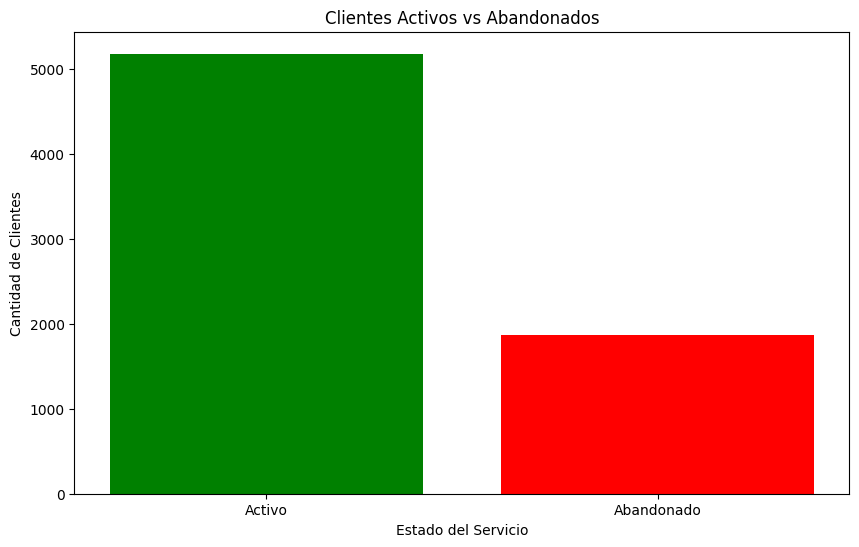

In [6]:
# Contar la cantidad de clientes que han abandonado y los que aún tienen el servicio activo
counts = df_combined['churn'].value_counts()

# Crear una gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(['Activo', 'Abandonado'], counts, color=['green', 'red'])
plt.xlabel('Estado del Servicio')
plt.ylabel('Cantidad de Clientes')
plt.title('Clientes Activos vs Abandonados')
plt.show()

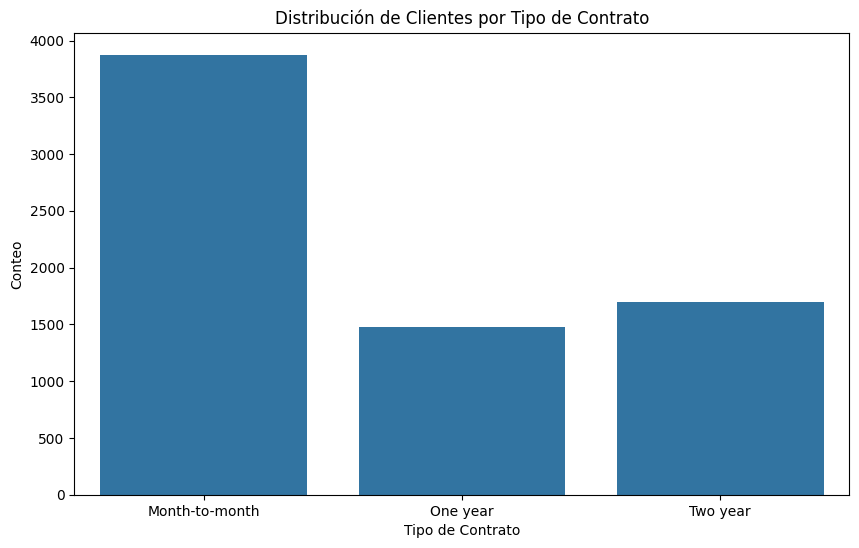

In [7]:
# Visualización de la distribución de clientes por tipo de contrato
plt.figure(figsize=(10, 6))
sns.countplot(x='type', data=df_contract)
plt.title('Distribución de Clientes por Tipo de Contrato')
plt.xlabel('Tipo de Contrato')
plt.ylabel('Conteo')
plt.show()

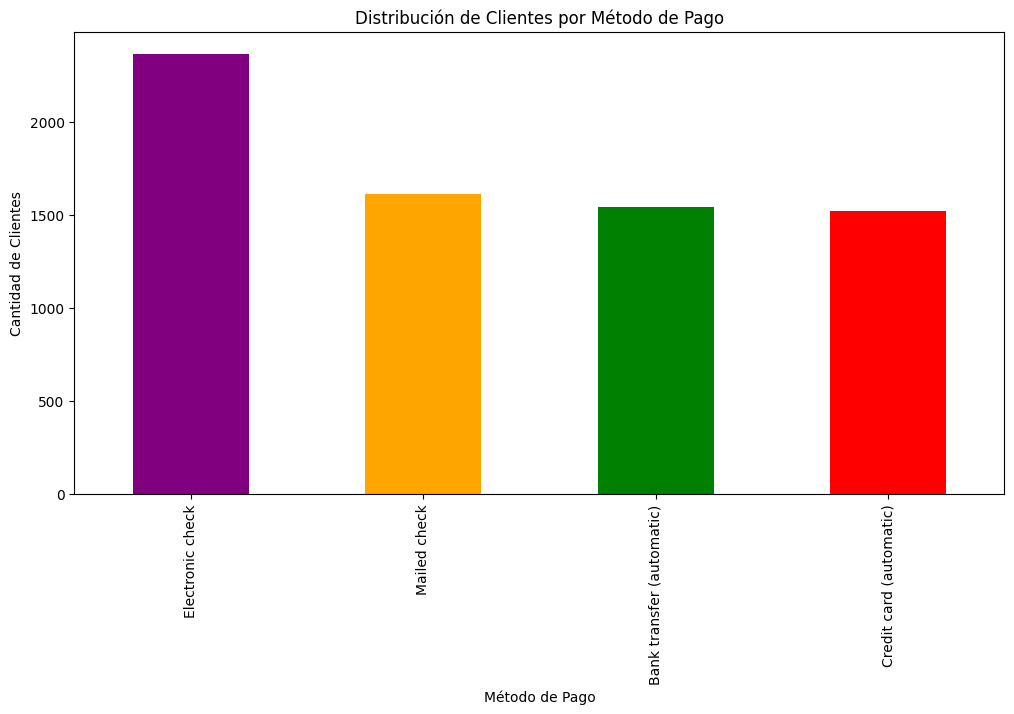

In [8]:
# Contar la cantidad de clientes por método de pago
payment_method_counts = df_combined['paymentmethod'].value_counts()

# Crear una gráfica de barras
plt.figure(figsize=(12, 6))
payment_method_counts.plot(kind='bar', color=['purple', 'orange', 'green', 'red'])
plt.xlabel('Método de Pago')
plt.ylabel('Cantidad de Clientes')
plt.title('Distribución de Clientes por Método de Pago')
plt.show()

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
No has incluido una sección de selección de características después de procesar las features en tu plan de trabajo. Este paso es fundamental en ciencia de datos porque no solo se trata de incluir todas las variables y entrenar modelos. La selección de características te ayudará a identificar las variables más relevantes y a eliminar aquellas que no aportan valor al modelo, mejorando así su rendimiento y reduciendo el tiempo de entrenamiento.

Te recomiendo encarecidamente agregar esta sección para asegurar que tu análisis y modelos sean robustos, eficientes y más fáciles de interpretar. En el comentario final del plan de trabajo, te he dejado una guía de más métodos para la selección de características.

</div>

<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> <a class=“tocSkip”></a>

Se aplico la seleccion de caracteristicas siguiendo el enfoque de filtrado anteriormente mencionado
</div>

# Seleccion de caracteristicas - Filtrado

In [9]:
# Separar características y variable objetivo
X = df_combined_ohe.drop(columns=['churn'])
y = df_combined_ohe['churn']

# Aplicar SMOTE para el sobremuestreo de la clase minoritaria
smote = SMOTE(random_state=12345)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Filtrado: Selección de características
X_filtrado, indices_filtrado = seleccion_caracteristicas_filtrado(X_resampled, y_resampled, k=20)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_filtrado, X_test_filtrado, y_train_filtrado, y_test_filtrado = train_test_split(X_filtrado, y_resampled, test_size=0.3, random_state=12345)


In [10]:
# Definir el grid de hiperparámetros para cada modelo
param_grid_log_reg = {
    'C': [0.01, 0.1, 1, 10, 100]
}

param_grid_tree = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Crear el objeto GridSearchCV para cada modelo
grid_log_reg = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_log_reg, cv=5, scoring='roc_auc')
grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_tree, cv=5, scoring='roc_auc')
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='roc_auc')
grid_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=5, scoring='roc_auc')

# Modelos

Evaluando modelo de Regresión Logística
Modelo: LogisticRegression
Conjunto de Entrenamiento
Accuracy: 0.7717796493165815
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.74      0.76      3647
           1       0.75      0.81      0.78      3596

    accuracy                           0.77      7243
   macro avg       0.77      0.77      0.77      7243
weighted avg       0.77      0.77      0.77      7243

Confusion Matrix:
 [[2681  966]
 [ 687 2909]]
Conjunto de Prueba
Accuracy: 0.7800322061191627
AUC-ROC: 0.8568490035300378
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.73      0.77      1527
           1       0.76      0.83      0.79      1578

    accuracy                           0.78      3105
   macro avg       0.78      0.78      0.78      3105
weighted avg       0.78      0.78      0.78      3105

Confusion Matrix:
 [[1119  408]
 [ 275 1303]]


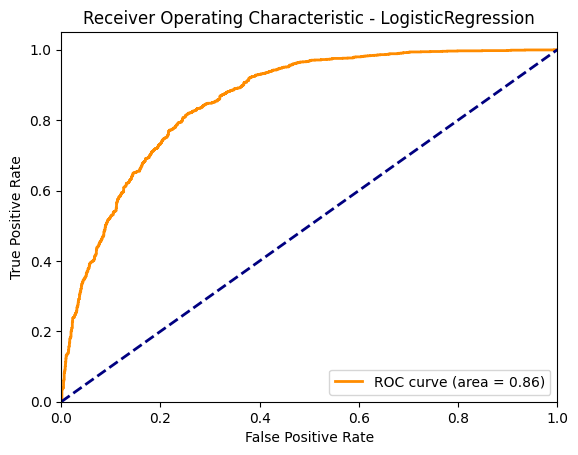

Mejores hiperparámetros: {'C': 10}
AUC-ROC: 0.8568490035300378
Accuracy: 0.7800322061191627
Tiempo de entrenamiento: 0.2341783046722412 segundos
--------------------------------------------------------------------------------


In [11]:
# Evaluar modelo de Regresión Logística
print("Evaluando modelo de Regresión Logística")
mejores_parametros_log_reg, auc_roc_log_reg, accuracy_log_reg, tiempo_log_reg = evaluar_y_medicion_tiempo(grid_log_reg, X_train_filtrado, y_train_filtrado, X_test_filtrado, y_test_filtrado)
print(f"Mejores hiperparámetros: {mejores_parametros_log_reg}")
print(f"AUC-ROC: {auc_roc_log_reg}")
print(f"Accuracy: {accuracy_log_reg}")
print(f"Tiempo de entrenamiento: {tiempo_log_reg} segundos")
print("-" * 80)

Evaluando modelo de Árbol de Decisión
Modelo: DecisionTreeClassifier
Conjunto de Entrenamiento
Accuracy: 0.8303189286207373
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.80      0.83      3647
           1       0.81      0.86      0.83      3596

    accuracy                           0.83      7243
   macro avg       0.83      0.83      0.83      7243
weighted avg       0.83      0.83      0.83      7243

Confusion Matrix:
 [[2914  733]
 [ 496 3100]]
Conjunto de Prueba
Accuracy: 0.7739130434782608
AUC-ROC: 0.8425005996831018
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.74      0.76      1527
           1       0.76      0.80      0.78      1578

    accuracy                           0.77      3105
   macro avg       0.77      0.77      0.77      3105
weighted avg       0.77      0.77      0.77      3105

Confusion Matrix:
 [[1134  393]
 [ 309 1269]]


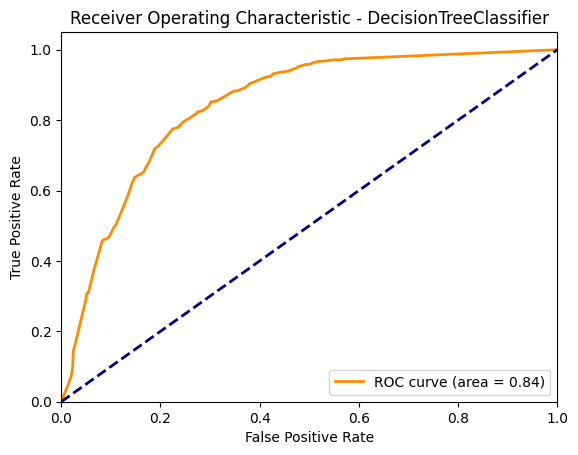

Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
AUC-ROC: 0.8425005996831018
Accuracy: 0.7739130434782608
Tiempo de entrenamiento: 2.570204257965088 segundos
--------------------------------------------------------------------------------


In [12]:
# Evaluar modelo de Árbol de Decisión
print("Evaluando modelo de Árbol de Decisión")
mejores_parametros_tree, auc_roc_tree, accuracy_tree, tiempo_tree = evaluar_y_medicion_tiempo(grid_tree, X_train_filtrado, y_train_filtrado, X_test_filtrado, y_test_filtrado)
print(f"Mejores hiperparámetros: {mejores_parametros_tree}")
print(f"AUC-ROC: {auc_roc_tree}")
print(f"Accuracy: {accuracy_tree}")
print(f"Tiempo de entrenamiento: {tiempo_tree} segundos")
print("-" * 80)

Evaluando modelo de Bosque Aleatorio
Modelo: RandomForestClassifier
Conjunto de Entrenamiento
Accuracy: 0.8499240646141102
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.80      0.84      3647
           1       0.81      0.90      0.86      3596

    accuracy                           0.85      7243
   macro avg       0.85      0.85      0.85      7243
weighted avg       0.85      0.85      0.85      7243

Confusion Matrix:
 [[2909  738]
 [ 349 3247]]
Conjunto de Prueba
Accuracy: 0.8038647342995169
AUC-ROC: 0.8789351869143753
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.76      0.79      1527
           1       0.78      0.85      0.81      1578

    accuracy                           0.80      3105
   macro avg       0.81      0.80      0.80      3105
weighted avg       0.81      0.80      0.80      3105

Confusion Matrix:
 [[1158  369]
 [ 240 1338]]


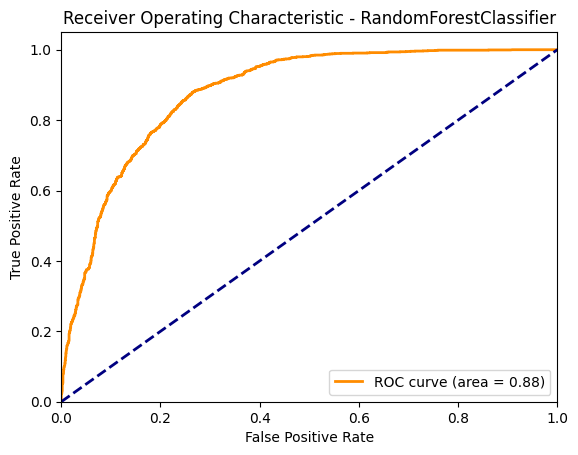

Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
AUC-ROC: 0.8789351869143753
Accuracy: 0.8038647342995169
Tiempo de entrenamiento: 343.94401502609253 segundos
--------------------------------------------------------------------------------


In [13]:
# Evaluar modelo de Bosque Aleatorio
print("Evaluando modelo de Bosque Aleatorio")
mejores_parametros_rf, auc_roc_rf, accuracy_rf, tiempo_rf = evaluar_y_medicion_tiempo(grid_rf, X_train_filtrado, y_train_filtrado, X_test_filtrado, y_test_filtrado)
print(f"Mejores hiperparámetros: {mejores_parametros_rf}")
print(f"AUC-ROC: {auc_roc_rf}")
print(f"Accuracy: {accuracy_rf}")
print(f"Tiempo de entrenamiento: {tiempo_rf} segundos")
print("-" * 80)

Evaluando modelo de Gradient Boosting
Modelo: GradientBoostingClassifier
Conjunto de Entrenamiento
Accuracy: 0.8209305536379953
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.79      0.82      3647
           1       0.80      0.85      0.82      3596

    accuracy                           0.82      7243
   macro avg       0.82      0.82      0.82      7243
weighted avg       0.82      0.82      0.82      7243

Confusion Matrix:
 [[2894  753]
 [ 544 3052]]
Conjunto de Prueba
Accuracy: 0.7903381642512077
AUC-ROC: 0.876409877797449
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.76      0.78      1527
           1       0.78      0.82      0.80      1578

    accuracy                           0.79      3105
   macro avg       0.79      0.79      0.79      3105
weighted avg       0.79      0.79      0.79      3105

Confusion Matrix:
 [[1161  366]
 [ 285 1293]]


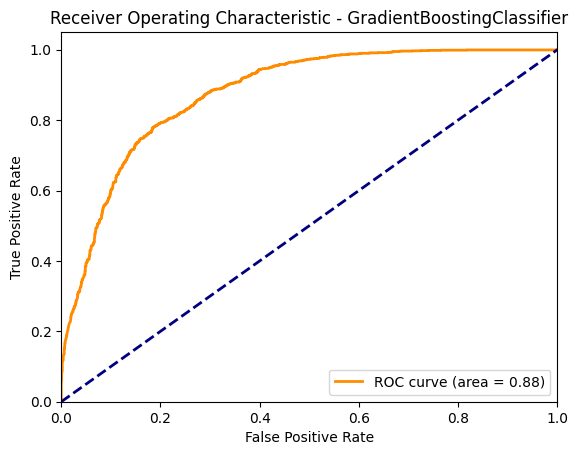

Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
AUC-ROC: 0.876409877797449
Accuracy: 0.7903381642512077
Tiempo de entrenamiento: 152.85751581192017 segundos
--------------------------------------------------------------------------------


In [14]:
# Evaluar modelo de Gradient Boosting
print("Evaluando modelo de Gradient Boosting")
mejores_parametros_gb, auc_roc_gb, accuracy_gb, tiempo_gb = evaluar_y_medicion_tiempo(grid_gb, X_train_filtrado, y_train_filtrado, X_test_filtrado, y_test_filtrado)
print(f"Mejores hiperparámetros: {mejores_parametros_gb}")
print(f"AUC-ROC: {auc_roc_gb}")
print(f"Accuracy: {accuracy_gb}")
print(f"Tiempo de entrenamiento: {tiempo_gb} segundos")
print("-" * 80)

## Resultados

1. Regresión Logística:

   - Mejores hiperparámetros: {'C': 100}
   - AUC-ROC: 0.8568490035300378
   - Accuracy: 0.7800322061191627
   - Tiempo de entrenamiento: 0.2341783046722412 segundos

2. Árbol de Decisión:

   - Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
   - AUC-ROC: 0.8425005996831018
   - Accuracy: 0.7739130434782608
   - Tiempo de entrenamiento: 2.570204257965088 segundos

3. Bosque Aleatorio:

   - Mejores hiperparámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
   - AUC-ROC: 0.8789351869143753
   - Accuracy: 0.8038647342995169
   - Tiempo de entrenamiento: 343.94401502609253 segundos

4. Gradient Boosting:

   - Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
   - AUC-ROC: 0.876409877797449
   - Accuracy: 0.7903381642512077
   - Tiempo de entrenamiento: 152.85751581192017 segundos

## Conclusion:

El modelo de Bosque aleatorio presenta un excelente rendimiento segun las metricas AUC-ROC y Accuracy sin embargo el tiempo de entrenamiento seria su principal punto en contra, si este no fuera una limitante este modelo se declara como el mejor de todos los presentados.

En caso de que el tiempo de entrenamiento sea una preocupacion el modelo de regresion logistica puede ser una buena alternativa ya que ofrece un balance entre rendimiento y tiempo de entrenamiento.

El Gradient Boosting también muestra un buen rendimiento, especialmente en términos de AUC-ROC, y su tiempo de entrenamiento es significativamente menor que el del Bosque Aleatorio, lo que lo convierte en una opción intermedia viable.